### **Anomaly detection on CPU usage**

Anomaly Detection means to identify unexpected events in a process. It means to detect threats to our systems that may cause harm in terms of security and leakage of important information, but the importance of Anomaly Detection is not limited to security. The data of this project is based on per-minute metrics of the host’s CPU utilization.

In [10]:
%%capture

!pip install -r ../requirements.txt

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
url_train_a = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv'
url_train_b = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv'
url_test_a = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv'
url_test_b = 'https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv'

df_train_a = pd.read_csv(url_train_a)
df_train_b = pd.read_csv(url_train_b)
df_test_a = pd.read_csv(url_test_a)
df_test_b = pd.read_csv(url_test_b)

df_train_a.to_csv('../data/raw/train_a.csv')
df_train_b.to_csv('../data/raw/train_b.csv')
df_test_a.to_csv('../data/raw/test_a.csv')
df_test_b.to_csv('../data/raw/test_b.csv')

### Dataset a

In [20]:
df_train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [5]:
df_train_a.sample(5)

,datetime,cpu
341,2017-01-28 00:23:00,0.68
49,2017-01-27 19:31:00,0.61
174,2017-01-27 21:36:00,0.79
50,2017-01-27 19:32:00,0.61
218,2017-01-27 22:20:00,0.82


In [13]:
df_train_a.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [5]:
df_train_a.duplicated().sum()

0

In [17]:
def preprocessing(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index(df['datetime'])
    df = df.drop(['datetime'], axis=1)
    return df

In [18]:
df_train_a = preprocessing(df_train_a)
df_train_a.to_csv('../data/processed/df_train_a_processed.csv')

In [25]:
df_train_a.head(5)

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08


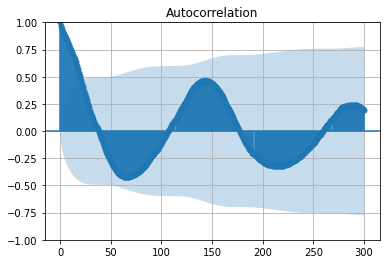

In [26]:
plot_acf(df_train_a.values, lags=300)
plt.grid()
plt.show()

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


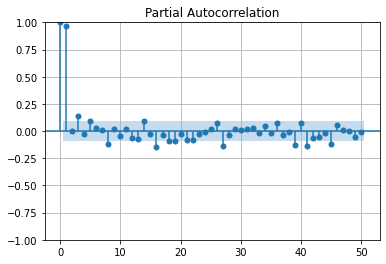

In [27]:
plot_pacf(df_train_a.values, lags=50)
plt.grid()
plt.show()

In [28]:
res = seasonal_decompose(df_train_a.values, period=144)

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

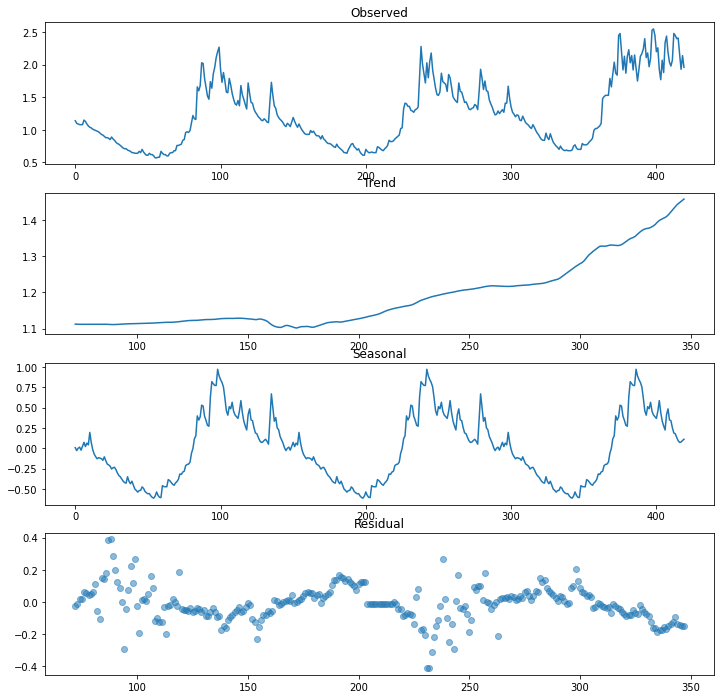

In [29]:
fig, ax = plt.subplots(4, figsize=(12, 12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

In [24]:
df_test_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  60 non-null     object 
 1   cpu       60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [23]:
stepwise_model = auto_arima(df_train_a, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-273.302, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-368.085, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-271.465, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-417.827, Time=2.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-419.762, Time=1.63 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-369.850, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=9.50 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.10 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-417.860, Time=3.12 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-421.259, Time=4.28 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-373.

In [30]:
stepwise_model.fit(df_train_a)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

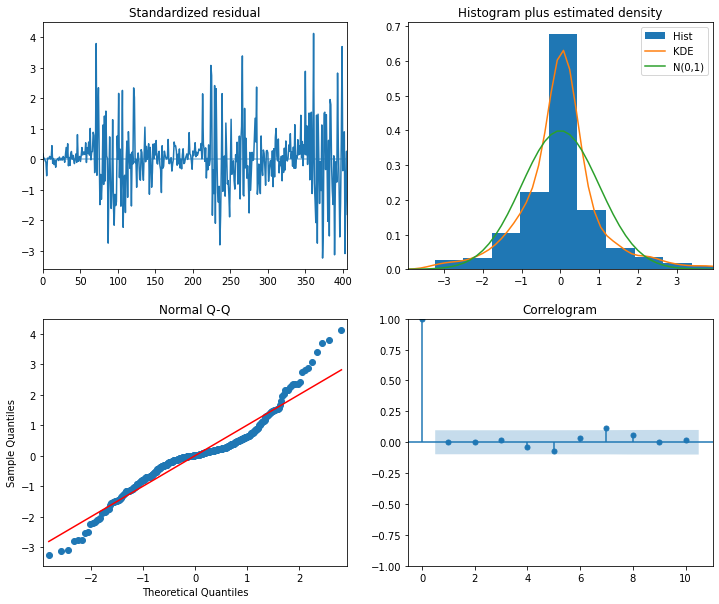

In [33]:
stepwise_model.fit(df_train_a).plot_diagnostics(figsize=(12, 10))
plt.show()

In [35]:
df_test_a = preprocessing(df_test_a)
df_test_a.to_csv('../data/processed/df_test_a_processed.csv')

In [34]:
future_forecast_a = stepwise_model.predict(n_periods=60)

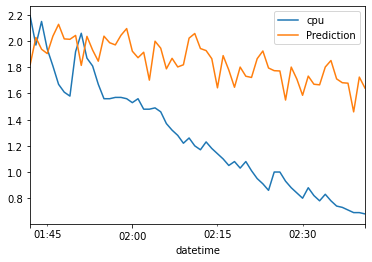

In [51]:
future_forecast_a = pd.DataFrame(future_forecast_a, index = df_test_a.index, columns=['Prediction'])
pd.concat([df_test_a, future_forecast_a],axis=1).plot()
plt.show()

### Dataset b

In [37]:
df_train_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [38]:
df_train_b.sample(5)

,datetime,cpu
293,2017-01-27 23:35:00,1.28
169,2017-01-27 21:31:00,0.86
353,2017-01-28 00:35:00,0.79
101,2017-01-27 20:23:00,1.73
221,2017-01-27 22:23:00,0.88


In [39]:
df_train_b.describe()

,cpu
count,600.000000
mean,1.282733
std,0.484951
min,0.570000
25%,0.840000
50%,1.240000
75%,1.610000
max,2.550000


In [13]:
df_train_b.duplicated().sum()

0

In [40]:
df_train_b = preprocessing(df_train_b)
df_train_b.to_csv('../data/processed/df_train_b_processed.csv')

In [41]:
df_train_b.head(5)

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08


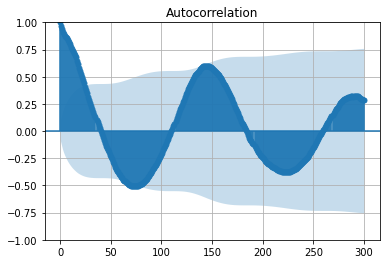

In [42]:
plot_acf(df_train_b.values, lags=300)
plt.grid()
plt.show()

In [43]:
res_b = seasonal_decompose(df_train_b.values, period=144)

res_observed_b = res_b.observed
res_trend_b = res_b.trend
res_seasonal_b = res_b.seasonal
res_residual_b = res_b.resid

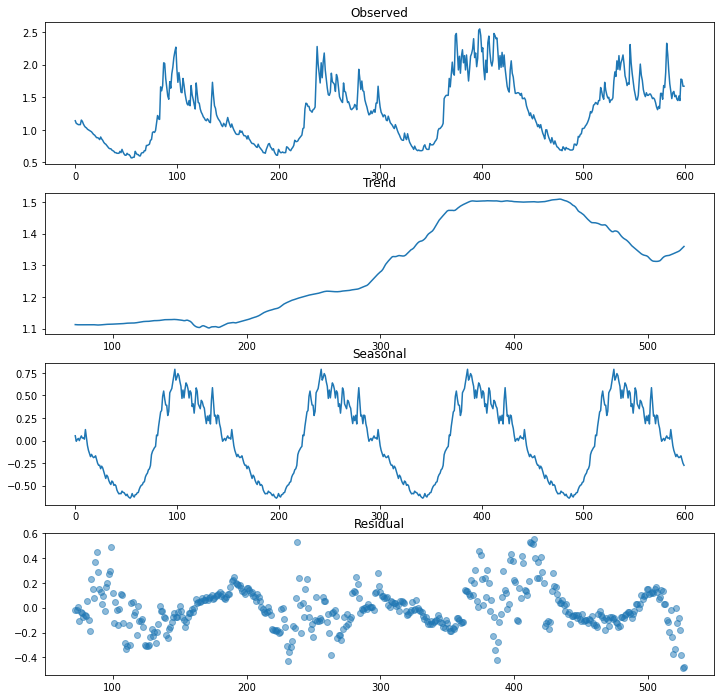

In [44]:
fig, ax = plt.subplots(4, figsize=(12, 12))

ax[0].set_title('Observed')
ax[0].plot(res_observed_b)

ax[1].set_title('Trend')
ax[1].plot(res_trend_b)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal_b)

ax[3].set_title('Residual')
ax[3].scatter(y=res_residual_b, x=range(len(res_residual_b)), alpha=0.5)

plt.show()

In [45]:
df_test_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  60 non-null     object 
 1   cpu       60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [46]:
stepwise_model_b = auto_arima(df_train_b, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_b.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-376.973, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-540.238, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-375.034, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-618.341, Time=2.38 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=14.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-619.706, Time=1.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-541.973, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=11.39 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-618.493, Time=2.52 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=11.18 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-617.729

In [47]:
stepwise_model_b.fit(df_train_b)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

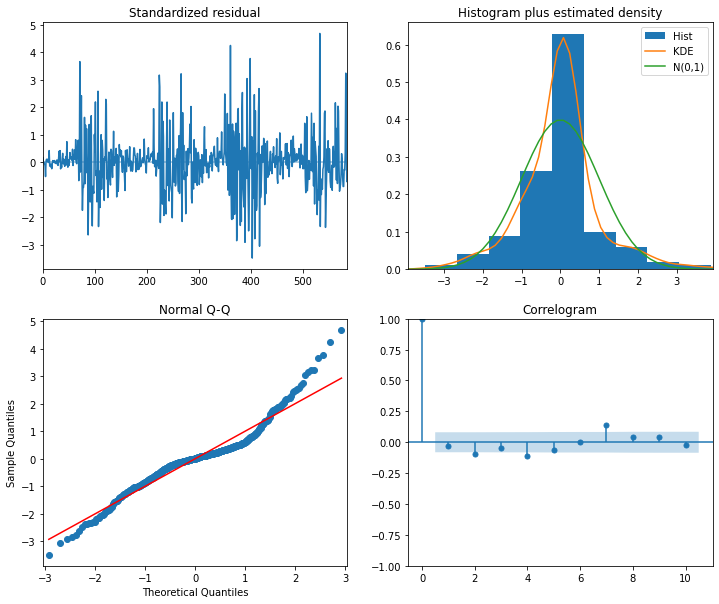

In [48]:
stepwise_model_b.fit(df_train_b).plot_diagnostics(figsize=(12, 10))
plt.show()

In [49]:
df_test_b = preprocessing(df_test_b)
df_test_b.to_csv('../data/processed/df_test_b_processed.csv')

In [50]:
future_forecast_b = stepwise_model_b.predict(n_periods=60)

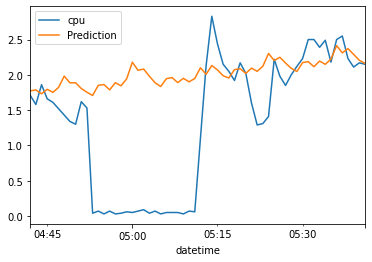

In [52]:
future_forecast_b = pd.DataFrame(future_forecast_b, index = df_test_b.index, columns=['Prediction'])
pd.concat([df_test_b, future_forecast_b],axis=1).plot()
plt.show()

Hay una anomalía desde 04:53 hasta 05:12

In [56]:
df_test_b

,cpu
datetime,
2017-01-28 04:42:00,1.71
2017-01-28 04:43:00,1.58
2017-01-28 04:44:00,1.86
2017-01-28 04:45:00,1.66
2017-01-28 04:46:00,1.61
2017-01-28 04:47:00,1.52
2017-01-28 04:48:00,1.43
2017-01-28 04:49:00,1.34
2017-01-28 04:50:00,1.30
